# exp037
all_times_aid featureリーク対策

In [22]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify
import my_logger
from noglobal import noglobal

# 設定

In [23]:
@dataclass
class Cfg:
    loglevel = "INFO"
    exp_name = "exp037"
    seed = 42
    k = 20
    cand_n = 10
    negative_sample = 1
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_weeks = ["week3"]
    valid_week = "week4"
    valid_session_n = 100_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)
random.seed(cfg.seed)

logger = my_logger.init_logger(cfg.exp_name)

In [24]:
class Cache:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self):
        self.cache_dir = (os.path.join(cfg.output_dir, cfg.exp_name, "cache"))
        self.cache_dir_path = pathlib.Path(self.cache_dir)
        self.caches = list(self.cache_dir_path.glob("*.pkl"))

    @noglobal(excepts=["cfg", "logger"])
    def get_abspath(self, filename):
        return (os.path.join(self.cache_dir, filename))
    
    @noglobal(excepts=["cfg", "logger"])
    def exists(self, path):
        return len([str(c) for c in self.caches if path == str(c)]) > 0


cache = Cache()

In [25]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [26]:
@noglobal(excepts=["cfg", "logger"])
def evaluate(clicks_labels, carts_labels, orders_labels, 
             clicks_preds, carts_preds, orders_preds, k=20):

    num_clicks = 0
    num_carts = 0
    num_orders = 0
    hit_clicks = 0
    hit_carts = 0
    hit_orders = 0

    for i in range(len(clicks_labels)):
        clicks_label = clicks_labels[i]
        carts_label = carts_labels[i]
        orders_label = orders_labels[i]
        clicks_pred = clicks_preds[i]
        carts_pred = carts_preds[i]
        orders_pred = orders_preds[i]

        if type(clicks_pred) == list:
            clicks_pred = clicks_pred[:k]
        else:
            clicks_pred = []
        if type(carts_pred) == list:
            carts_pred = carts_pred[:k]
        else:
            carts_pred = []    
        if type(orders_pred) == list:
            orders_pred = orders_pred[:k]
        else:
            orders_pred = []

        if not np.isnan(clicks_label):
            num_clicks += 1
            hit_clicks += int(clicks_label in clicks_pred)

        if type(carts_label) == list:
            num_carts += min(len(carts_label), k)
            hit_carts += len(set(carts_pred) & set(carts_label))
            
        if type(orders_label) == list:
            num_orders += min(len(orders_label), k)
            hit_orders += len(set(orders_pred) & set(orders_label))


    recall_clicks = hit_clicks / num_clicks
    recall_carts = hit_carts / num_carts
    recall_orders = hit_orders / num_orders
    w_recall_clicks = recall_clicks * 0.10
    w_recall_carts = recall_carts * 0.30
    w_recall_orders = recall_orders * 0.60
    score = w_recall_clicks + w_recall_carts + w_recall_orders

    results = {}
    results["num_clicks"] = num_clicks
    results["hit_clicks"] = hit_clicks
    results["num_carts"] = num_carts
    results["hit_carts"] = hit_carts
    results["num_orders"] = num_orders
    results["hit_orders"] = hit_orders
    results["recall_clicks"] = format(recall_clicks, ".3f")
    results["recall_carts"] = format(recall_carts, ".3f")
    results["recall_orders"] = format(recall_orders, ".3f")
    results["w_recall_clicks"] = format(w_recall_clicks, ".3f")
    results["w_recall_carts"] = format(w_recall_carts, ".3f")
    results["w_recall_orders"] = format(w_recall_orders, ".3f")
    results["score"] = format(score, ".3f")

    return results

In [27]:
class Candidate:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, pdf, labels=None):
        self.df = cudf.from_pandas(pdf)
        self.target_sessions = pdf["session"].unique().tolist()
        self.results = pd.DataFrame(columns=["name", "num_clicks", "hit_clicks", "num_carts", "hit_carts", "num_orders", "hit_orders", 
                                             "recall_clicks", "recall_carts", "recall_orders", "w_recall_clicks", "w_recall_carts", "w_recall_orders", "score"])
        self.output = pd.DataFrame(columns=["session", "aid"], dtype=int)
        self.labels = labels
    
    @noglobal(excepts=["cfg", "logger"])
    def _entry(self, new_candidate_df, name, k):
        logger.info(f"[add_candidate] {name} : start")
        new_candidate_df[f"{name}_rank"] = new_candidate_df.groupby("session")["session"].cumcount()
        new_candidate_df = new_candidate_df.to_pandas()
        self.output = pd.concat([self.output, new_candidate_df[["session", "aid"]]])
        self.output = self.output.drop_duplicates(subset=["session", "aid"])
        
        self.output = self.output.merge(new_candidate_df, on=["session", "aid"], how="left")

        if self.labels is not None:
            self._eval(new_candidate_df[["session", "aid"]], name, k)
    
    @noglobal(excepts=["cfg", "logger"])
    def _eval(self, new_candidate_df, name, k):
        new_candidate_df = new_candidate_df.groupby("session")["aid"].apply(list).reset_index()
        eval_df = pd.DataFrame(self.target_sessions, columns=["session"])
        eval_df = eval_df.merge(new_candidate_df, on=["session"], how="left")
        assert eval_df["session"].tolist() == self.labels["session"].tolist()
        eval_result = evaluate(self.labels["clicks_labels"].tolist(), self.labels["carts_labels"].tolist(), self.labels["orders_labels"].tolist(),
                               eval_df["aid"].tolist(), eval_df["aid"].tolist(), eval_df["aid"].tolist(), k)
        
        print(eval_result)
        self.results = pd.concat([self.results, pd.DataFrame([[name] + list(eval_result.values())], columns=["name"] + list(eval_result.keys()))])

    @noglobal(excepts=["cfg", "logger"])
    def add(self, strategy, name, usetypes=['clicks', 'carts', 'orders'], trans_map=None, k=20):
        logger.info(f"[make_candidate] {name} : start")
        candidate_df = self.df[self.df["type"].isin(usetypes)].copy()
        
        if strategy == "session_frequent":
            candidate_df = self._session_frequent(candidate_df, k)
        elif strategy == "session_latest":
            candidate_df = self._session_latest(candidate_df, k)
        elif strategy == "total_frequent":
            candidate_df = self._total_frequent(candidate_df, k)
        
        if trans_map is not None:
            candidate_df["aid"] = candidate_df["aid"].map(trans_map)
            candidate_df = candidate_df.dropna(subset=["aid"])
            
        self._entry(candidate_df, name, k)

    @noglobal(excepts=["cfg", "logger"])
    def _session_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby(["session", "aid"])["ts"].count().reset_index()
        candidate_df.columns = ["session", "aid", "aid_count"]
        candidate_df = candidate_df.sort_values(["session", "aid_count", "aid"], ascending=(True, False, True))
        candidate_df = candidate_df[candidate_df.groupby("session")["aid_count"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _session_latest(self, candidate_df, k):
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False)).drop_duplicates(subset=["session", "aid"])
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False))[candidate_df.groupby("session")["ts"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _total_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby("aid")["ts"].count().reset_index()
        candidate_df.columns = ["aid", "aid_count"]
        topk_freq_aids = candidate_df.sort_values("aid_count", ascending=False)["aid"].to_arrow().to_pylist()[:k]
        sessions = []
        aids = []
        for session, aid in itertools.product(self.target_sessions, topk_freq_aids):
            sessions.append(session)
            aids.append(aid)
        candidate_df = cudf.DataFrame({"session": sessions, "aid": aids})
        return candidate_df


In [28]:
@noglobal(excepts=["cfg", "logger"])
def add_labels(df, labels, type_):
    type_labels = labels[["session", f"{type_}_labels"]].dropna().copy()
    type_labels.columns = ["session", "aid"]
    type_labels = type_labels.explode("aid")
    type_labels["labels"] = 1
    df = df.merge(type_labels, on=["session", "aid"], how="left")
    df["labels"] = df["labels"].fillna(0)
    return df    

In [29]:
@noglobal(excepts=["cfg", "logger"])
def add_ground_truth_candidate(df, labels, type_):
    gt = labels[["session", f"{type_}_labels"]].dropna().copy()
    gt.columns = ["session", "aid"]
    gt = gt.explode("aid")
    df = pd.concat([df, gt])
    df = df.drop_duplicates()
    return df

In [30]:
@noglobal(excepts=["cfg", "logger"])
def under_sampling(df, label_col):
    cfg = Cfg()
    pos_df = df[df[label_col]==1].copy()
    neg_df = df[df[label_col]==0].copy()
    pos_n = len(pos_df)
    return pd.concat([pos_df, neg_df.sample(pos_n * cfg.negative_sample, random_state=cfg.seed)])

In [31]:
class Features:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, sessions, candidate, week):
        self.sessions = cudf.from_pandas(sessions)
        self.output = candidate
        self.type_dict = cfg.type2id
        self.week = week

    @noglobal(excepts=["cfg", "logger"])
    def add_features(self):
            self._prep()
            self._session_cnt()
            self._session_aid_nunique()
            self._session_last_type()
            # self._session_last_dt()
            self._aid_cnt()
            self._all_times_aid_features()
            # self._session_mean_ts()
            # self._aid_mean_ts()
            # self._aid_cnt_ratio_at_session_last()
            # self.output = self.output.drop(columns=["session_last_day"]) # 日時はtrainセット内のみで有効なので削除

    @noglobal(excepts=["cfg", "logger"])
    def _prep(self):
        logger.info("[features] prep : start")
        # ts関連の前処理
        self.sessions["relative_ts"] = self.sessions["ts"] - self.sessions["ts"].min()
        self.sessions["dt"] = cudf.to_datetime(self.sessions["ts"], unit="ms")
        self.sessions["hour"] = self.sessions["dt"].dt.hour
        self.sessions["week"] = self.sessions["dt"].dt.dayofweek
        self.sessions["day"] = self.sessions["dt"].dt.day
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_cnt(self):
        logger.info("[features] session_cnt : start")
        agg_df = self.sessions.groupby(["session", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})
        # session_total_cnt
        features = agg_df.groupby("session")["cnt"].sum().reset_index().rename(columns={"cnt": "session_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_total_cnt"] = self.output["session_total_cnt"].fillna(0)
        # session_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"session_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_aid_nunique(self):
        logger.info("[features] session_aid_nunique : start")
        features = self.sessions.groupby("session")["aid"].nunique().reset_index().rename(columns={"aid": "session_aid_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_aid_nunique"] = self.output["session_aid_nunique"].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_type(self):
        logger.info("[features] session_last_type : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "type"]]
        features = features.rename(columns={"type": "session_last_type"})
        features["session_last_type"] = features["session_last_type"].map(self.type_dict)
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_dt(self):
        logger.info("[features] session_last_dt : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "relative_ts", "week", "day", "hour"]]
        features.columns = ["session", "session_last_ts", "session_last_week", "session_last_day", "session_last_hour"]
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_mean_ts(self):
        logger.info("[features] session_mean_ts : start")
        features = self.sessions.groupby("session")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "session_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_mean_ts(self):
        logger.info("[features] aid_mean_ts : start")
        features = self.sessions.groupby("aid")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "aid_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")
       
    @noglobal(excepts=["cfg", "logger"])
    def _aid_session_nunique(self):
        logger.info("[features] aid_session_unique : start")
        features = self.sessions.groupby("aid")["session"].nunique().reset_index().rename(columns={"session": "aid_session_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")

    @noglobal(excepts=["cfg", "logger"]) 
    def _aid_cnt_ratio_at_session_last(self):
        logger.info("[features] aid_cnt_ratio_atsession_last : start")
        for dt_ in ["week", "day", "hour"]:
            features = self.sessions[["aid", dt_]].copy()
            features["total_cnt"] = features.groupby(dt_)["aid"].transform("count")
            features = features.groupby(["aid", dt_])["total_cnt"].agg(["count", "max"]).reset_index()
            features[f"aid_cnt_ratio_at_session_last_{dt_}"] = features["count"] / features["max"]
            features = features.rename(columns={dt_: f"session_last_{dt_}"})
            self.output = self.output.merge(features[["aid", f"session_last_{dt_}", f"aid_cnt_ratio_at_session_last_{dt_}"]].to_pandas(), on=["aid", f"session_last_{dt_}"], how="left")
            self.output[f"aid_cnt_ratio_at_session_last_{dt_}"] = self.output[f"aid_cnt_ratio_at_session_last_{dt_}"].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_cnt(self):
        logger.info("[features] aid_cnt : start")
        agg_df = self.sessions.groupby(["session", "aid", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})

        # aid_total_cnt
        features = agg_df.groupby(["session", "aid"])["cnt"].sum().reset_index().rename(columns={"cnt": "aid_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
        self.output["aid_total_cnt"] = self.output["aid_total_cnt"].fillna(0)

        # aid_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"aid_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", "aid", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)

    @noglobal(excepts=["cfg", "logger"])
    def _all_times_aid_features(self):
        feats = ["all_times_aid_freq",
                 "all_times_aid_clicks_freq",
                 "all_times_aid_carts_freq",
                 "all_times_aid_orders_freq",
                 "all_times_aid_session_freq",
                 "all_times_aid_session_clicks_freq",
                 "all_times_aid_session_carts_freq",
                 "all_times_aid_session_orders_freq",
                 "all_times_aid_carts_ratio_with_clicks",
                 "all_times_aid_orders_ratio_with_clicks",
                 "all_times_aid_date_std",
                 "all_times_aid_hour_std",
                 "all_times_aid_day_of_week_std"]
        
        for feat in feats:
            if self.week is None:
                with open(cfg.prep_dir + f"{feat}.pkl", "rb") as f:
                    feat_map = pickle.load(f)
            else:
                with open(cfg.prep_dir + f"{feat}_{self.week}.pkl", "rb") as f:
                    feat_map = pickle.load(f)
            self.output[feat] = self.output["aid"].map(feat_map)


In [32]:
@noglobal(excepts=["cfg", "logger"])
def add_features(sessions, cand_df, week=None):
    feat = Features(sessions, cand_df, week)
    feat.add_features()
    return feat.output

In [33]:
@noglobal(excepts=["cfg", "logger"])
def make_cand_df(sessions, labels=None, trans_maps=None):

    if labels is not None:
         cand = Candidate(sessions, labels)
    else:
        cand = Candidate(sessions)

    cand.add(strategy="session_frequent", name="session_frequent", k=cfg.cand_n)
    cand.add(strategy="session_latest", name="session_latest", k=cfg.cand_n)
    # cand.add(strategy="total_frequent", name="total_frequent", k=cfg.cand_n)
    cand.add(strategy="session_frequent", trans_map=trans_maps["pair0"], name="session_frequent_pair", k=cfg.cand_n)
    
    for i in range(10):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"pair{str(i)}"], name=f"session_latest_pair{str(i)}", k=cfg.cand_n)
    
    for i in range(10):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"time_wt_pair{str(i)}"], name=f"session_latest_time_wt_pair{str(i)}", k=cfg.cand_n)
    
    cand.add(strategy="session_latest", trans_map=trans_maps["type_wt_pair"], name="session_latest_type_wt_pair", k=cfg.cand_n)
    cand.add(strategy="session_latest", trans_map=trans_maps["clicks2carts_pair"], name="session_latest_clicks2carts_pair", k=cfg.cand_n)
    cand.add(strategy="session_latest", trans_map=trans_maps["clicks2orders_pair"], name="session_latest_clicks2orders_pair", k=cfg.cand_n)
    if labels is not None:
        return cand.output, cand.results
    else:
        return cand.output

In [34]:
@noglobal(excepts=["cfg", "logger"])
def get_trans_maps():
    """
    aidを別のaidに置き換えるmapping辞書を取得する
    """
    trans_maps = {}

    pair_df_org = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_v5.pkl")
    pair_df_org = pair_df_org[pair_df_org["cnt"] > 3].copy()
    pair_df_org = pair_df_org.sort_values(["aid_x", "cnt"], ascending=(True, False))
    for i in range(10):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"pair{str(i)}"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_clicks.pkl")
    pair_df = pair_df[pair_df["cnt"] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["clicks_pair"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_carts.pkl")
    pair_df = pair_df[pair_df["cnt"] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["carts_pair"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_orders.pkl")
    pair_df = pair_df[pair_df["cnt"] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["orders_pair"] = pair_dict

    pair_df_org = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_time_weighted_v2.pkl")
    pair_df_org = pair_df_org.sort_values(["aid_x", "wt"], ascending=(True, False))
    for i in range(10):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"time_wt_pair{str(i)}"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_type_weighted.pkl")
    pair_df = pair_df.sort_values(["aid_x", "wt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["type_wt_pair"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_clicks2carts.pkl")
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["clicks2carts_pair"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_clicks2orders.pkl")
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["clicks2orders_pair"] = pair_dict

    return trans_maps


In [35]:
@noglobal(excepts=["cfg", "logger", "cache"])
def make_train_data(trans_maps, type_):
    dfs = []
    for weeks in cfg.train_weeks:
        # データ読み込み
        week_sessions = pd.read_pickle(cfg.prep_dir + f"train_sessions_{weeks}.pkl")
        week_labels = pd.read_pickle(cfg.prep_dir + f"labels_{weeks}.pkl")
        
        cache_file = f"train_cand_{weeks}.pkl"
        cache_path = cache.get_abspath(cache_file)
        print(cache_path)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            cand_df = pd.read_pickle(cache_path)
        else:
            # 候補選出
            cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
            cand_df = reduce_mem_usage(cand_df)
            cand_df.to_pickle(cache_path)

        cand_df = add_labels(cand_df, week_labels, type_)
        cand_df = under_sampling(cand_df, "labels")

        # 特徴量付与
        train_tmp = add_features(week_sessions, cand_df, weeks)
        dfs.append(train_tmp)
        del cand_df, train_tmp
        gc.collect()
        
    train = pd.concat(dfs)
    train = train.reset_index(drop=True)
    train = reduce_mem_usage(train)
    
    return train

In [36]:
@noglobal(excepts=["cfg", "logger"])
def make_valid_cand(trans_maps):
    valid_week = cfg.valid_week
    # データ読み込み
    week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{valid_week}.pkl")
    week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{valid_week}.pkl")
    valid_session_ids = week_sessions["session"].unique().tolist()

    # validに使うsessionを絞る
    valid_session_n = min(cfg.valid_session_n, len(valid_session_ids))
    random.seed(cfg.seed)
    valid_session_ids = random.sample(valid_session_ids, valid_session_n)
    week_sessions = week_sessions[week_sessions["session"].isin(valid_session_ids)].copy()
    week_labels = week_labels[week_labels["session"].isin(valid_session_ids)].copy()

    # 候補選出
    cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
    cand_df = reduce_mem_usage(cand_df)
    return cand_df, week_sessions, week_labels

In [37]:
@noglobal(excepts=["cfg", "logger"])
def make_valid_data(cand_df, week_sessions, week_labels, type_):
    # 特徴量付与
    valid = add_features(week_sessions, cand_df, cfg.valid_week)
    valid = add_labels(valid, week_labels, type_)
    valid = valid.reset_index(drop=True)
    valid = reduce_mem_usage(valid)
    return valid

In [38]:
@noglobal(excepts=["cfg", "logger"])
def model_training(train, valid, features, target, valid_labels, type_):
    params = {'objective': 'binary', 
            'boosting': 'gbdt', 
            'learning_rate': 0.1, 
            'metric': 'binary_logloss', 
            'seed': cfg.seed
            }

    # 学習
    vl_pred_df = valid[["session", "aid"]].copy()

    tr_x, tr_y = train[features], train[target]
    vl_x, vl_y = valid[features], valid[target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)

    # 特徴量重要度
    fi = pd.DataFrame()
    fi["feature"] = model.feature_name()
    fi["importance"] = model.feature_importance(importance_type="gain")

    # 2値分類の出力を元にk個選定
    vl_pred_df["prob"] = model.predict(vl_x, num_iteration=model.best_iteration)
    vl_pred_df = vl_pred_df.sort_values(["session", "prob"], ascending=(True, False))
    vl_pred_df = vl_pred_df.groupby(["session"]).head(cfg.k)
    vl_pred_df = vl_pred_df.groupby(["session"])["aid"].apply(list).reset_index()
    
    # 評価
    assert valid_labels["session"].tolist() == vl_pred_df["session"].unique().tolist()
    score = evaluate(valid_labels["clicks_labels"].tolist(),
                     valid_labels["carts_labels"].tolist(),
                     valid_labels["orders_labels"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     vl_pred_df["aid"].tolist(),
                     cfg.k)
    logger.info(f"{type_} valid score")
    logger.info(score)

    # モデル保存
    model.save_model(cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")

    # 特徴量重要度
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance({type_})")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance_{type_}.png')

    return score[f"recall_{type_}"]

In [39]:
@noglobal(excepts=["cfg", "logger"])
def make_test_data(trans_maps):
    # testデータ作成
    test_sessions = pd.read_pickle(cfg.prep_dir + f"test_sessions.pkl")

    dfs =[]
    # 候補選出
    logger.info("[make_test] make_cand_df")
    cand_df = make_cand_df(test_sessions, trans_maps=trans_maps)
    cand_df = reduce_mem_usage(cand_df)
    # 特徴量付与
    logger.info("[make_test] add_features")
    test = add_features(test_sessions, cand_df)
    test = reduce_mem_usage(test)

    return test

In [40]:
@noglobal(excepts=["cfg", "logger"])
def inference(test, features):
    pred_dfs = []
    for type_ in ["clicks", "carts", "orders"]:
        pred_df_tmp = test[["session", "aid"]].copy()
        # 推論
        model = lgb.Booster(model_file = cfg.output_dir + f"{cfg.exp_name}/{type_}_model.lgb")

        # 2値分類の出力を元にk個選定
        pred_df_tmp["prob"] = model.predict(test[features], num_iteration=model.best_iteration)
        pred_df_tmp = pred_df_tmp.sort_values(["session", "prob"], ascending=(True, False))
        pred_df_tmp = pred_df_tmp.groupby(["session"]).head(cfg.k)
        pred_df_tmp["aid"] = pred_df_tmp["aid"].astype(str)
        pred_df_tmp = pred_df_tmp.groupby(["session"])["aid"].apply(list).reset_index()
        pred_df_tmp["aid"] = pred_df_tmp["aid"].apply(lambda x: ' '.join(x))
        pred_df_tmp["type"] = type_
        pred_dfs.append(pred_df_tmp)
    del test, model
    gc.collect()
    
    pred_df = pd.concat(pred_dfs)
    # sub作成
    sub = pd.read_csv(cfg.input_dir + f"sample_submission.csv", usecols=["session_type"])
    pred_df["session_type"] = pred_df["session"].astype(str) + "_" + pred_df["type"]
    pred_df = pred_df.rename(columns={"aid": "labels"})
    sub = sub.merge(pred_df[["session_type", "labels"]], on="session_type", how="left")
    sub.to_csv(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_sub.csv", index=False)

In [41]:
@noglobal(excepts=["cfg", "logger", "cache"])
def main():
    scores = {}
    logger.info(f"START")
    line_notify.send(f"{cfg.exp_name} | START")
    
    # trans_map作成
    cache_file = "trans_maps.pkl"
    cache_path = cache.get_abspath(cache_file)
    if cache.exists(cache_path):
        logger.info(f"[{cache_file}] cache exists. load cache and skip process.")
        with open(cache_path, "rb") as f:
            trans_maps = pickle.load(f)
    else:
        trans_maps = get_trans_maps()
        with open(cache_path, "wb") as f:
            pickle.dump(trans_maps, f)

    for type_ in ["clicks", "carts", "orders"]:
        # train data作成
        logger.info(f"make {type_}_train_data")
        cache_file = f"{type_}_train.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            train = pd.read_pickle(cache_path)
        else:
            train = make_train_data(trans_maps, type_)
            train.to_pickle(cache_path)
        
        logger.info(f"make {type_}_valid_data")
        # valid cand作成
        cand_cache_path = cache.get_abspath("valid_cand.pkl")
        sessions_cache_path = cache.get_abspath("valid_sessions.pkl")
        labels_cache_path = cache.get_abspath("valid_labels.pkl")
        if cache.exists(cand_cache_path) & cache.exists(labels_cache_path) & cache.exists(sessions_cache_path):
            logger.info("[valid_cand.pkl] cache exists. read cache and skip process.")
            valid_cand = pd.read_pickle(cand_cache_path)
            valid_sessions = pd.read_pickle(sessions_cache_path)
            valid_labels = pd.read_pickle(labels_cache_path)
        else:
            valid_cand, valid_sessions, valid_labels = make_valid_cand(trans_maps)
            valid_cand.to_pickle(cand_cache_path)
            valid_sessions.to_pickle(sessions_cache_path)
            valid_labels.to_pickle(labels_cache_path)

        # valid data作成
        logger.info(f"make {type_}_valid_data")
        cache_file = f"{type_}_valid.pkl"
        cache_path = cache.get_abspath(cache_file)
        if cache.exists(cache_path):
            logger.info(f"[{cache_file}] cache exists. read cache and skip process.")
            valid = pd.read_pickle(cache_path)
        else:
            valid = make_valid_data(valid_cand, valid_sessions, valid_labels, type_)
            valid.to_pickle(cache_path)

        # モデル学習
        target = "labels"
        not_use_cols = ["session", "aid", target]
        features = [c for c in train.columns if c not in not_use_cols]

        scores[f"recall_{type_}"] = model_training(train, valid, features, target, valid_labels, type_)

        del train, valid, valid_labels
        gc.collect()
    
    scores["total"] = (float(scores["recall_clicks"]) * 0.1) + (float(scores["recall_carts"]) * 0.3) + (float(scores["recall_orders"]) * 0.6)
    report = f"\n{cfg.exp_name}\n"
    report += f'valid_end\n'
    report += str(scores)
    line_notify.send(report)

    # testデータ
    cache_path = cache.get_abspath("test.pkl")
    if cache.exists(cache_path):
        logger.info("cache exists. read cache and skip process.")
        test = pd.read_pickle(cache_path)
    else:
        test = make_test_data(trans_maps)
        test.to_pickle(cache_path)

    logger.info(f"-------- inference --------")
    inference(test, features)

    line_notify.send(f"{cfg.exp_name} | END!!")

0:00:00.779480 	 START
0:00:00.914635 	 [trans_maps.pkl] cache exists. load cache and skip process.
0:00:05.626688 	 make clicks_train_data
0:00:11.950408 	 [train_cand_week3.pkl] cache exists. read cache and skip process.


/mnt/otto-recommender-system/output/exp037/cache/train_cand_week3.pkl


0:03:11.014419 	 [features] prep : start
0:03:11.059053 	 [features] session_cnt : start
0:03:20.424855 	 [features] session_aid_nunique : start
0:03:23.086682 	 [features] session_last_type : start
0:03:26.053136 	 [features] aid_cnt : start


Memory usage of dataframe is 1187.64 MB
Memory usage after optimization is: 541.14 MB
Decreased by 54.4%


0:04:05.963579 	 make clicks_valid_data
0:04:05.964615 	 [valid_cand.pkl] cache exists. read cache and skip process.
0:04:07.077200 	 make clicks_valid_data
0:04:07.105967 	 [features] prep : start
0:04:07.120410 	 [features] session_cnt : start
0:04:09.491902 	 [features] session_aid_nunique : start
0:04:10.097801 	 [features] session_last_type : start
0:04:10.769250 	 [features] aid_cnt : start


Memory usage of dataframe is 959.28 MB
Memory usage after optimization is: 429.35 MB
Decreased by 55.2%


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 2510741, number of negative: 2510741
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.373886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4273
[LightGBM] [Info] Number of data points in the train set: 5021482, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.409085	valid_1's binary_logloss: 0.401453
[200]	training's binary_logloss: 0.406889	valid_1's binary_logloss: 0.399402
[300]	training's binary_logloss: 0.405666	valid_1's binary_logloss: 0.398462
[400]	training's binary_logloss: 0.404622	valid_1's binary_logloss: 0.397815
[500]	training's binary_logloss: 0.403661	valid_1's binary_logloss: 0.397199
[600]	training's binary_logloss: 0.402855

0:08:48.551946 	 clicks valid score
0:08:48.553729 	 {'num_clicks': 97136, 'hit_clicks': 50874, 'num_carts': 43211, 'hit_carts': 15931, 'num_orders': 20082, 'hit_orders': 11730, 'recall_clicks': '0.524', 'recall_carts': '0.369', 'recall_orders': '0.584', 'w_recall_clicks': '0.052', 'w_recall_carts': '0.111', 'w_recall_orders': '0.350', 'score': '0.513'}
0:08:49.220697 	 make carts_train_data
0:08:55.343161 	 [train_cand_week3.pkl] cache exists. read cache and skip process.


/mnt/otto-recommender-system/output/exp037/cache/train_cand_week3.pkl


0:11:36.332850 	 [features] prep : start
0:11:36.477627 	 [features] session_cnt : start
0:11:40.793295 	 [features] session_aid_nunique : start
0:11:42.533602 	 [features] session_last_type : start
0:11:44.289039 	 [features] aid_cnt : start


Memory usage of dataframe is 427.05 MB


0:12:31.171711 	 make carts_valid_data
0:12:31.173186 	 [valid_cand.pkl] cache exists. read cache and skip process.


Memory usage after optimization is: 210.99 MB
Decreased by 50.6%


0:12:31.553398 	 make carts_valid_data
0:12:31.581894 	 [features] prep : start
0:12:31.595784 	 [features] session_cnt : start
0:12:33.526292 	 [features] session_aid_nunique : start
0:12:34.065503 	 [features] session_last_type : start
0:12:34.647473 	 [features] aid_cnt : start


Memory usage of dataframe is 974.75 MB
Memory usage after optimization is: 450.31 MB
Decreased by 53.8%


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 888490, number of negative: 888490
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4372
[LightGBM] [Info] Number of data points in the train set: 1776980, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.413402	valid_1's binary_logloss: 0.403874
[200]	training's binary_logloss: 0.407498	valid_1's binary_logloss: 0.398461
[300]	training's binary_logloss: 0.404788	valid_1's binary_logloss: 0.396866
[400]	training's binary_logloss: 0.402733	valid_1's binary_logloss: 0.396061
[500]	training's binary_logloss: 0.400974	valid_1's binary_logloss: 0.39557
[600]	training's binary_logloss: 0.399331	va

0:14:43.930250 	 carts valid score
0:14:43.931549 	 {'num_clicks': 97136, 'hit_clicks': 48450, 'num_carts': 43211, 'hit_carts': 16911, 'num_orders': 20082, 'hit_orders': 12287, 'recall_clicks': '0.499', 'recall_carts': '0.391', 'recall_orders': '0.612', 'w_recall_clicks': '0.050', 'w_recall_carts': '0.117', 'w_recall_orders': '0.367', 'score': '0.534'}
0:14:44.525964 	 make orders_train_data
0:14:50.338657 	 [train_cand_week3.pkl] cache exists. read cache and skip process.


/mnt/otto-recommender-system/output/exp037/cache/train_cand_week3.pkl


0:17:21.026224 	 [features] prep : start
0:17:21.157369 	 [features] session_cnt : start
0:17:24.336162 	 [features] session_aid_nunique : start
0:17:25.757795 	 [features] session_last_type : start
0:17:27.195714 	 [features] aid_cnt : start


Memory usage of dataframe is 301.39 MB


0:18:10.667981 	 make orders_valid_data
0:18:10.669384 	 [valid_cand.pkl] cache exists. read cache and skip process.


Memory usage after optimization is: 145.90 MB
Decreased by 51.6%


0:18:11.038071 	 make orders_valid_data
0:18:11.070489 	 [features] prep : start
0:18:11.085147 	 [features] session_cnt : start
0:18:12.913879 	 [features] session_aid_nunique : start
0:18:13.412960 	 [features] session_last_type : start
0:18:13.989253 	 [features] aid_cnt : start


Memory usage of dataframe is 974.75 MB
Memory usage after optimization is: 450.31 MB
Decreased by 53.8%


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 627051, number of negative: 627051
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4383
[LightGBM] [Info] Number of data points in the train set: 1254102, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.271519	valid_1's binary_logloss: 0.25595
[200]	training's binary_logloss: 0.265776	valid_1's binary_logloss: 0.252266
[300]	training's binary_logloss: 0.262813	valid_1's binary_logloss: 0.251476
[400]	training's binary_logloss: 0.260415	valid_1's binary_logloss: 0.251059
[500]	training's binary_logloss: 0.258191	valid_1's binary_logloss: 0.250744
[600]	training's binary_logloss: 0.256228	va

0:19:42.746426 	 orders valid score
0:19:42.747736 	 {'num_clicks': 97136, 'hit_clicks': 46580, 'num_carts': 43211, 'hit_carts': 16335, 'num_orders': 20082, 'hit_orders': 12405, 'recall_clicks': '0.480', 'recall_carts': '0.378', 'recall_orders': '0.618', 'w_recall_clicks': '0.048', 'w_recall_carts': '0.113', 'w_recall_orders': '0.371', 'score': '0.532'}
0:19:44.358002 	 [make_test] make_cand_df
0:19:44.671621 	 [make_candidate] session_frequent : start
0:19:45.185479 	 [add_candidate] session_frequent : start
0:19:47.030005 	 [make_candidate] session_latest : start
0:19:47.488266 	 [add_candidate] session_latest : start
0:19:49.799042 	 [make_candidate] session_frequent_pair : start
0:19:50.479771 	 [add_candidate] session_frequent_pair : start
0:19:54.077369 	 [make_candidate] session_latest_pair0 : start
0:19:54.890177 	 [add_candidate] session_latest_pair0 : start
0:19:59.150747 	 [make_candidate] session_latest_pair1 : start
0:19:59.947093 	 [add_candidate] session_latest_pair1 : s

Memory usage of dataframe is 12284.22 MB


0:29:43.159659 	 [make_test] add_features


Memory usage after optimization is: 3600.55 MB
Decreased by 70.7%


0:29:43.414703 	 [features] prep : start
0:29:43.457415 	 [features] session_cnt : start
0:30:16.861216 	 [features] session_aid_nunique : start
0:30:26.157800 	 [features] session_last_type : start
0:30:35.865989 	 [features] aid_cnt : start


Memory usage of dataframe is 13131.41 MB
Memory usage after optimization is: 6512.76 MB
Decreased by 50.4%


0:33:11.917716 	 -------- inference --------


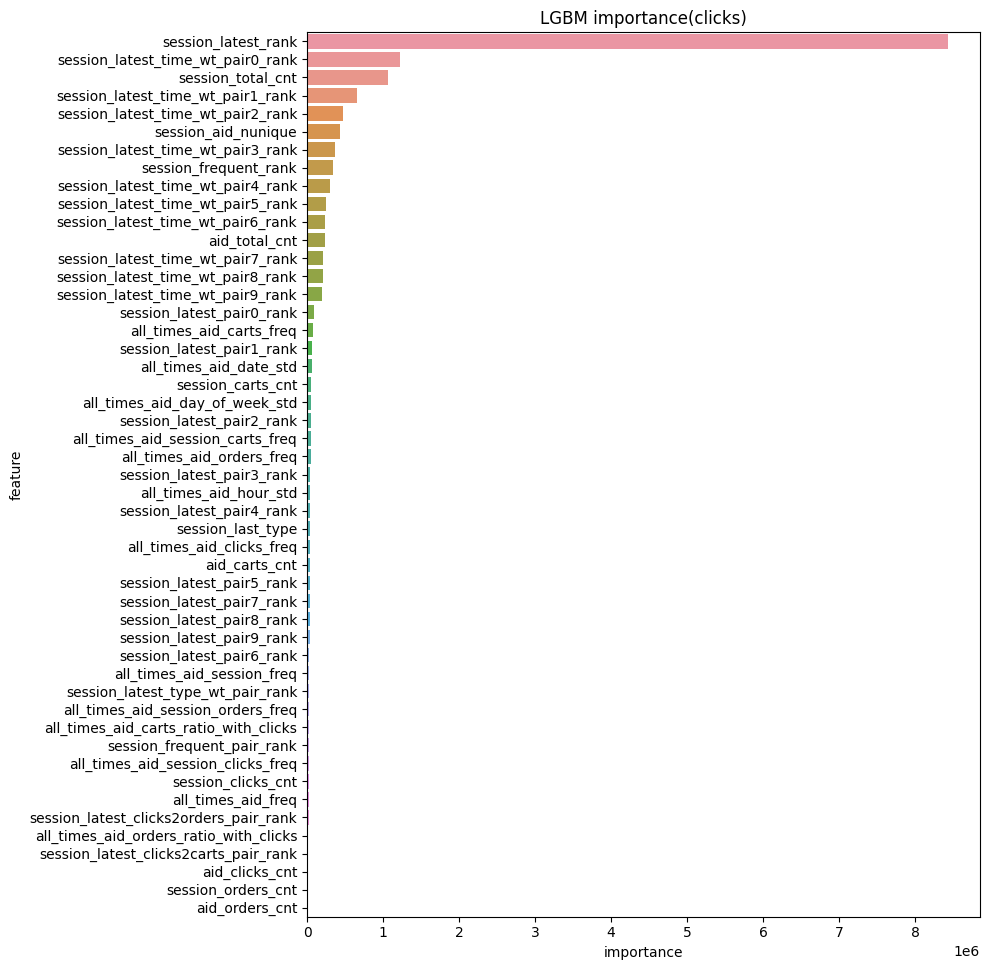

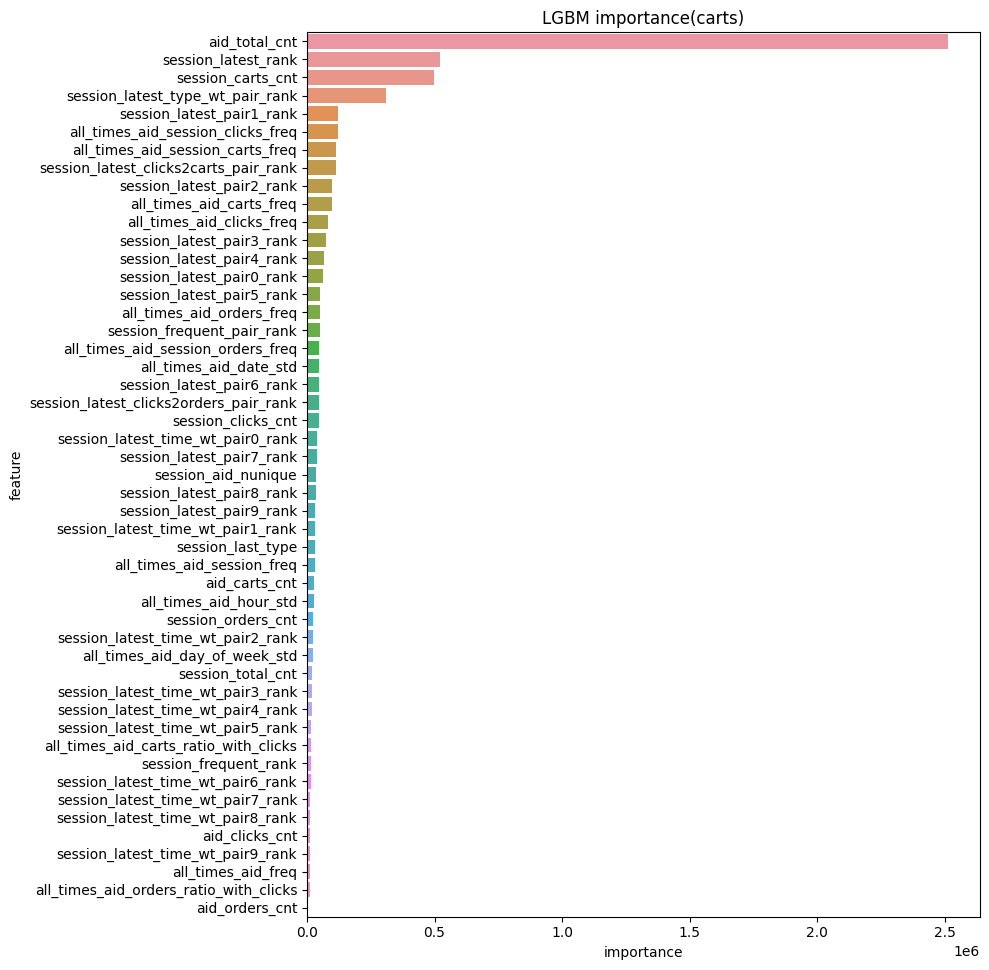

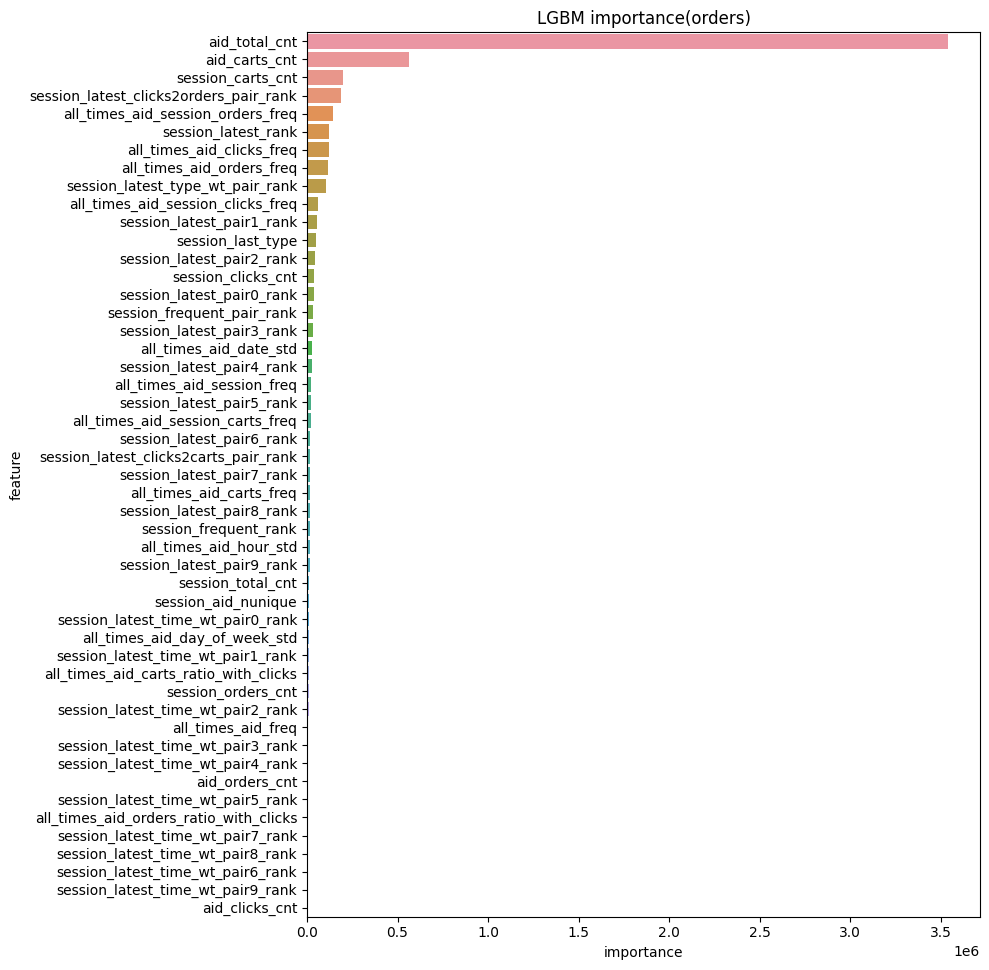

In [42]:
try:
    main()
except Exception as e:
    logger.error(traceback.format_exc())
    line_notify.send(f"{cfg.exp_name} | ERROR!!\n{traceback.format_exc()}")